# Keras CIFAR-10 Training Pipeline

Here we show how to build pipelines to train a Keras (Tensorflow backend) models with a GPU. Here we use the classic CIFAR-10 data set, because its a bit more interesting than MNIST. 

In [32]:
#suppress tf warnings 
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import numpy as np
import pickle 
import os
from glob import glob

from matplotlib import pyplot as plt
%matplotlib inline

from tensorflow.keras.utils import to_categorical

from minipipe import Source, Sink, Transform, Pipeline, Stream

## Simple Pipeline

First we'll look at a simple sequential pipeline with only three pipe segments, a loader, preprocessor and trainer. Mimipipe is useful for training with large data sets that won't fit in local memory. 

In [133]:
def load_data(file):
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
        X, y = data[b'data'], data[b'labels']
        return X, y 

@Source
def loader_gen(data_dir, epochs=1, batch_size=32):
    files = glob(os.path.join(data_dir, 'data_batch_*'))
    for epoch in range(epochs):
        for f in files:
            X, y = load_data(f)
            for i in range(len(X)//batch_size):
                yield X[i*batch_size:(i+1)*batch_size], y[i*batch_size:(i+1)*batch_size]

@Transform
def preprocess(data, batch_size=32):
    X, y = data
    
    # One-hot-encode y values
    y = to_categorical(y, num_classes=10)
    
    # Reshape data to 3 rgb channels of 32x32 images
    X = X.reshape((batch_size, 3, 32, 32))
    X = np.transpose(X, (0, 2, 3, 1))
    
    # Convert to float32 and normalize 
    X = X.astype('float32')
    X = X/255.0
    
    return X, y

Now we can load and look at the data. 

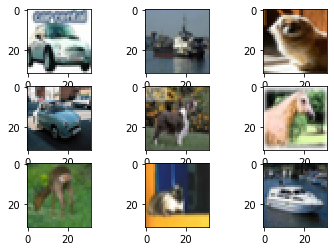

In [126]:
data_dir = '/hdd/data/tutorials/cifar-10-batches-py'
data = next(loader_gen(data_dir))
X, y = preprocess(data)

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X[i])
plt.show()

In [120]:
data[0].shape

(32, 3072)

Next we define the model build function. To keep this function thread-safe we load all its Tensorflow dependancies in the funtion itself. This is highly recommended for all GPU enabled modules. 

In [127]:
# define cnn model
def build_model(n_vgg_blocks):
    
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D
    from tensorflow.keras.layers import MaxPooling2D
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import Flatten
    from tensorflow.keras.optimizers import SGD
    
    # Ask Tensorflow to use only as much GPU memory as needed
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    tf.Session(config=config)
    
    model = Sequential()
    
    for vgg_block in range(n_vgg_blocks):
        n_filters = 2**(vgg_block + 5)
        
        model.add(Conv2D(n_filters, (3, 3), activation='relu', 
                         kernel_initializer='he_uniform', padding='same', 
                         input_shape=(32, 32, 3) if vgg_block==0 else (None,)))
        
        model.add(Conv2D(n_filters, (3, 3), activation='relu', 
                         kernel_initializer='he_uniform', padding='same'))
        
        model.add(MaxPooling2D((2, 2)))
        
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Now we can define the trainer class. We'll want to save the model once the pipeline is finished running so we'll use the class decorator `Sink.term` on the `save_model` method. Typically When using a GPU you will need to define the model on the child process. We can do this by running the `build_model` function once on the child process at initiation, this is done using the `Sink.init` decorator. However `__init__` should be run on the main process before you start the pipeline, which is useful for setting class parameters. 

In [128]:
# Keras Trainer class
# This class will train a model via keras' model.fit 

@Sink
class train_keras:
    
    def __init__(self, n_vgg_blocks, save_name):
        self.save_name = save_name
        self.n_vgg_blocks = n_vgg_blocks
    
    @Sink.init
    def build_model(self):
        self.model = build_model(self.n_vgg_blocks)
        
    @Sink.call    
    def fit(self, data):
        X, y = data
        self.model.train_on_batch(X, y)
        
    @Sink.term    
    def save_model(self):
        print("Saving model to {}".format(self.save_name))
        self.model.save(self.save_name)

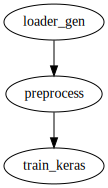

In [129]:
data_dir = '/hdd/data/tutorials/cifar-10-batches-py'
loader = loader_gen(data_dir, epochs=1)

trainer = train_keras(n_vgg_blocks=3, save_name='keras_model.hdf5')

# Build and display pipeline
pline = (Pipeline()
         .add(loader)
         .add(preprocess)
         .add(trainer)
         .build())

pline.diagram()

In [130]:
#run pipeline
pline.run(timeit=True, units='s')

2020-05-03 11:11:53,603 - INFO - loader_gen - End of stream
2020-05-03 11:11:53,639 - INFO - loader_gen - Local termination
2020-05-03 11:11:53,718 - INFO - preprocess - Local termination
2020-05-03 11:11:53,759 - INFO - train_keras - Local termination


Saving model to keras_model.hdf5


2020-05-03 11:11:54,049 - INFO - main - Warm-up time: 0.05s
2020-05-03 11:11:54,051 - INFO - main - Run time: 54.84s
2020-05-03 11:11:54,051 - INFO - main - Total time: 54.89s


## Evaluation while Training

Keras can track some metrics during training, such as log loss and accuracy. However, these metrics are all calulated on the training set. Furthermore, more sophisticated metrics such as AUC  (or in this case multi-class AUC) cannot be calcualted during training with Keras. In this section we'll show how you can perform evalution of AUC on a test/validaton set in parallel with training. 

There are two ways of doing this; persist a model at each step in `train_keras` and have a downstream pipe segment load that model and perform evaluation, or pass the model weights to the downstream and load them into the evaluation model. We'll take the latter approach to avoid the delay of writting to disk. We'll have to modify our `train_keras` class so it can be used as a transform and define a evalution sink. 

1562.5

In [145]:
from sklearn.metrics import roc_auc_score 

def multiclass_auc(y, p):
    return roc_auc_score(y, p, multi_class='ovo', average='macro')

@Transform
class train_keras:
    
    def __init__(self, n_vgg_blocks, save_name, batches_per_step=400):
        self.save_name = save_name
        self.n_vgg_blocks = n_vgg_blocks
        self.batches_per_step = batches_per_step
        self.batch = 0
    
    @Transform.init
    def build_model(self):
        self.model = build_model(self.n_vgg_blocks)
        
    @Transform.call    
    def fit(self, data):
        X, y = data
        self.model.train_on_batch(X, y)
        self.batch += 1
        if self.batch % self.batches_per_step == 0:
            res = self.model.get_weights()
        else:
            res = None
        return res 
    
    @Transform.term    
    def save_model(self):
        print("Saving model to {}".format(self.save_name))
        self.model.save(self.save_name)

@Sink
class eval_keras:
    
    def __init__(self,n_vgg_blocks, test_data):
        self.X_test, self.y_test = test_data
        self.n_labels = self.y_test.shape[1]
        self.n_vgg_blocks = n_vgg_blocks
    
    @Sink.init
    def local_init(self):           
        self.model = build_model(self.n_vgg_blocks)
        self.aucs = []
    
    @Sink.call
    def eval_auc(self, weights):
        self.model.set_weights(weights)
        p = self.model.predict_on_batch(self.X_test) 
        test_auc = multiclass_auc(self.y_test, p)
        print('Multi-class AUC: {0:0.4f}'.format(test_auc))
        self.aucs.append(test_auc)
    
    @Sink.term
    def plot_auc(self):
        plt.plot(range(len(self.aucs)), self.aucs)
        plt.xlabel('step')
        plt.ylabel('Multi-class AUC')
        plt.show()

We've suppressed the Keras training and prediction progress bars with `verbose=0`. Otherwise our print outs can get jumbled with them, making the output hard to read. Now we can build a pipeline with our four pipe segments: load, process, train, eval. 

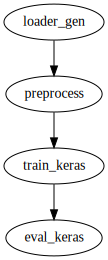

In [146]:
loader = loader_gen(data_dir, epochs=1)

trainer = train_keras(n_vgg_blocks=3, save_name='vgg1_model.hdf5')

# Generate a test set for the evaluator to use
test_data = '/hdd/data/tutorials/cifar-10-batches-py/test_batch'
test_data = load_batch(test_data)
test_data = preprocess(test_data, batch_size=10000)
evaluator = eval_keras(n_vgg_blocks=3, test_data=test_data)

# Build and display pipeline
pline2 = (Pipeline()
          .add(loader)
          .add(preprocess)
          .add(trainer)
          .add(evaluator)
          .build())

pline2.diagram()

Multi-class AUC: 0.8319
Multi-class AUC: 0.8657
Multi-class AUC: 0.8875


2020-05-03 11:25:51,773 - INFO - loader_gen - End of stream
2020-05-03 11:25:51,808 - INFO - loader_gen - Local termination
2020-05-03 11:25:51,881 - INFO - preprocess - Local termination
2020-05-03 11:25:51,922 - INFO - train_keras - Local termination


Saving model to vgg1_model.hdf5


2020-05-03 11:25:51,923 - INFO - eval_keras - Local termination


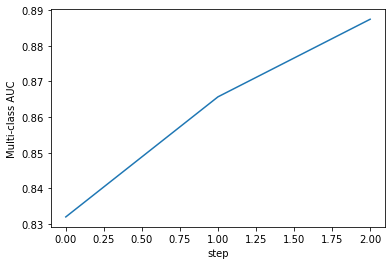

2020-05-03 11:25:52,156 - INFO - main - Warm-up time: 0.07s
2020-05-03 11:25:52,158 - INFO - main - Run time: 61.65s
2020-05-03 11:25:52,159 - INFO - main - Total time: 61.72s


In [147]:
#run pipeline
pline2.run(timeit=True, units='s')

Note that eventhough we're doing prediction and evaluation at each step the total time is still only about 30s. This is because prediction and evaluation are happening in parallel with training. And since training is the bottleneck they add little to the total time.

## Training with Multiple Models (Single GPU). 

Now that we have our basic pipeline working we'll probably want to experiment with other models and architectures. We could try each architecture one-by-one, but if we're working with large data sets this may be prohibitively time consuming. However, with MiniPipe we can train and test them all in parallel. We're only restricted by the memory of our GPU and number of physical CPU cores. 

We'll try training three models in parallel. We'll have to make some modifications to our functors. First `preprocess` needs to return three copies of the data, one for each trainer. Second `eval_keras` needs to be a transform, passing the evaluations results (AUCs) to a pipe segment that accumulates them and plots at termination. 

In [163]:
from collections import defaultdict

@Transform
def preprocess(data):
    X, y = data
    
    # One-hot-encode y values
    y = to_categorical(y, num_classes=10)
    
    # Reshape data to 3 rgb channels of 32x32 images
    X = X.reshape((len(X), 3, 32, 32))
    X = np.transpose(X, (0, 2, 3, 1))
    
    # Convert to float32 and normalize 
    X = X.astype('float32')
    X = X/255.0
    
    data = X, y
    return data, data, data

@Transform
class train_keras:
    
    def __init__(self, n_vgg_blocks, model_name, batches_per_step=400):
        self.model_name = model_name
        self.n_vgg_blocks = n_vgg_blocks
        self.batches_per_step = batches_per_step
        self.batch = 0
    
    @Transform.init
    def build_model(self):
        self.model = build_model(self.n_vgg_blocks)
        
    @Transform.call    
    def fit(self, data):
        X, y = data
        self.model.train_on_batch(X, y)
        self.batch += 1
        if self.batch % self.batches_per_step == 0:
            res = self.model_name, self.model.get_weights()
        else:
            res = None
        return res
    
    @Transform.term    
    def save_model(self):
        print("Saving model to {}".format(self.model_name))
        self.model.save(self.model_name)

@Transform
class eval_keras:
    
    def __init__(self,n_vgg_blocks, test_data):
        self.X_test, self.y_test = test_data
        self.n_labels = self.y_test.shape[1]
        self.n_vgg_blocks = n_vgg_blocks
    
    @Transform.init
    def build_model(self):           
        self.model = build_model(self.n_vgg_blocks)
        self.aucs = []
    
    @Transform.call
    def eval_auc(self, name_weights):
        model_name, weights = name_weights
        self.model.set_weights(weights)
        p = self.model.predict_on_batch(self.X_test) 
        test_auc = multiclass_auc(self.y_test, p)
        print(f'[{model_name}] Multi-class AUC: {test_auc:0.4f}')
        self.aucs.append(test_auc)
        return (model_name, test_auc)

@Sink
class plot_aucs:
    
    def local_init(self):
        self.auc_dict = defaultdict(list)
        
    def local_call(self, name_auc):
        name, test_auc = name_auc
        self.auc_dict[name].append(test_auc)
    
    def local_term(self):
        for name, test_auc in self.auc_dict.items():
            plt.plot(range(len(test_auc)), test_auc, label=name)
        plt.legend()
        plt.xlabel('step')
        plt.ylabel('Multi-class AUC')
        plt.title('Model Architecture Search')
        plt.show()

Since this pipeline will have multiple branches we'll need to use the PipeSystem API. In the PipeSystem API we need to define all the Streams explicitly. We'll use a dictionary to store all the model architectures and names. If we want to add more models we can simply expand this dictionary. 

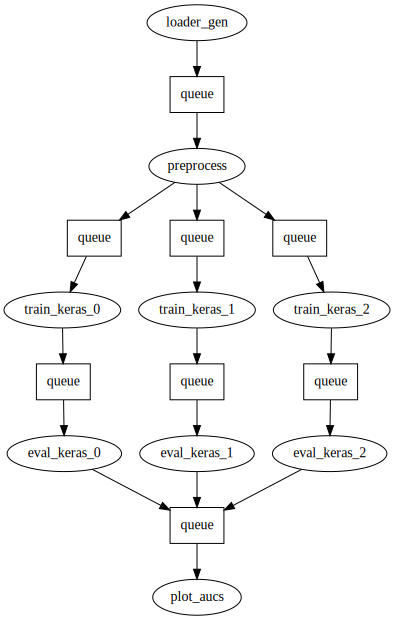

In [166]:
plasma=True

# Init generator (optional) and class functors
loader = loader_gen(data_dir, epochs=1)

# Define VGG hidden architectures
vgg_archs = {'vgg-1':3, 'vgg-2':3, 'vgg-3':3}

# Define trainer fuctors 
trainers = [train_keras(arch, name) for name, arch in vgg_archs.items()]

# Generate a test set for the evaluator to use
test_data = '/hdd/data/tutorials/cifar-10-batches-py/test_batch'
test_data = load_batch(test_data)
test_data, *_ = preprocess(test_data)

# Define evaluator functors with same test set
evaluators = [eval_keras(arch, test_data) for arch in vgg_archs.values()]

# Define Streams
train_streams = [Stream(plasma=False) for _ in range(len(vgg_archs))]
eval_streams = [Stream(plasma=False) for _ in range(len(vgg_archs))]
s_ldr, s_plt = Stream(plasma=False), Stream(plasma=False)

psys = (Pipeline(plasma=False)
        .add(loader)
        .add(preprocess, downstream=train_streams))
        
for trnr, evlr, s_tr, s_evl in zip(trainers, evaluators, train_streams, eval_streams):
    psys.add(trnr, upstream=s_tr, downstream=s_evl)
    psys.add(evlr, upstream=s_evl, downstream=s_plt)
psys.add(plot_aucs(), upstream=s_plt)

psys.build() 
psys.diagram(True)

Now when we build the pipeline we just need to supply `PipeSystem` with a list of pipe segments. 

[vgg-3] Multi-class AUC: 0.8199
[vgg-2] Multi-class AUC: 0.8333
[vgg-1] Multi-class AUC: 0.8184
[vgg-2] Multi-class AUC: 0.8624
[vgg-1] Multi-class AUC: 0.8594
[vgg-3] Multi-class AUC: 0.8600
[vgg-1] Multi-class AUC: 0.8806
[vgg-3] Multi-class AUC: 0.8825
[vgg-2] Multi-class AUC: 0.8863


2020-05-03 11:41:49,157 - INFO - loader_gen - End of stream
2020-05-03 11:41:49,255 - INFO - loader_gen - Local termination
2020-05-03 11:41:49,368 - INFO - eval_keras_0 - Local termination
2020-05-03 11:41:49,368 - INFO - train_keras_0 - Local termination


Saving model to vgg-1


2020-05-03 11:41:49,439 - INFO - train_keras_1 - Local termination
2020-05-03 11:41:49,441 - INFO - eval_keras_1 - Local termination


Saving model to vgg-2


2020-05-03 11:41:49,472 - INFO - train_keras_2 - Local termination
2020-05-03 11:41:49,472 - INFO - eval_keras_2 - Local termination
2020-05-03 11:41:49,472 - INFO - preprocess - Local termination


Saving model to vgg-3


2020-05-03 11:41:49,473 - INFO - plot_aucs - Local termination


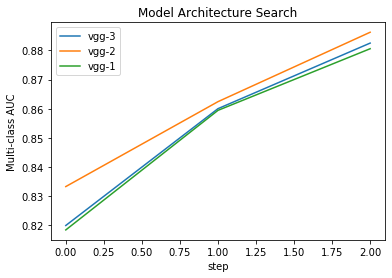

2020-05-03 11:41:49,877 - INFO - main - Warm-up time: 0.14s
2020-05-03 11:41:49,879 - INFO - main - Run time: 166.50s
2020-05-03 11:41:49,880 - INFO - main - Total time: 166.64s


In [167]:
psys.run(timeit=True, units='s')

Training four models only takes an additional few seconds! In fact this additional time can be contributed to the larger network architecture (keras-128-64-32-16). This model has more weights and thus takes longer to train. The pipeline is only has fast as it's slowest component, so it has to wait untill all models finish training before it terminates. We can see from the logs that keras-128-64-32-16 (Train3/Eval3)is indeed that last to terminate. 